# **Dos modelos básicos de clasificación: KNN y Bayes ingenuo**

El objetivo de este libro de notas es presentar las técnicas de K vecinos más cercanos y Naive Bayes como alternativas al problema de clasificación.

In [ ]:
if (!require('readxl')) install.packages('readxl')
if (!require('caret')) install.packages('caret')
if (!require('MLmetrics')) install.packages('MLmetrics')
if (!require('e1071')) install.packages('e1071')

Loading required package: readxl

Loading required package: caret

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘caret’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: MLmetrics

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘MLmetrics’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’, ‘ROCR’


Loading required package: e1071



## **KNN**

#Data and business understanding

In [ ]:
library(readxl)
library(caret)
library(MLmetrics)
library(ROCR)
library(e1071)

Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘MLmetrics’


The following objects are masked from ‘package:caret’:

    MAE, RMSE


The following object is masked from ‘package:base’:

    Recall




Trabajaremos con el contexto del archivo de cartera de empresas. Para mantener los libros de nota modulares, repetiré aquí el contexto:

In [ ]:
cartera<-read_excel("carteraguia2017.xlsx")

In [ ]:
str(cartera)

tibble [852 × 9] (S3: tbl_df/tbl/data.frame)
 $ MESES                   : num [1:852] 41 27 40 41 24 41 39 43 24 36 ...
 $ TIPO_ips                : num [1:852] 3 1 1 1 2 2 1 1 1 1 ...
 $ IGUAL_DUENO             : num [1:852] 17 10 15 15 2 5 20 12 3 0 ...
 $ AGNOS_DIRECCION_ACTUAL  : num [1:852] 12 6 14 14 0 5 9 11 4 13 ...
 $ VENTAS_MENS_PROMEDIO    : num [1:852] 176 31 55 120 28 25 67 38 19 25 ...
 $ PORC_PASIVOS_VENTA_ANUAL: num [1:852] 9.3 17.3 5.5 2.9 17.3 10.2 30.6 3.6 24.4 19.7 ...
 $ cartera_actual_insumos_A: num [1:852] 11.359 1.362 0.856 2.659 1.787 ...
 $ cartera_actual_insumos_B: num [1:852] 5.009 4.001 2.169 0.821 3.057 ...
 $ retrasos                : num [1:852] 1 0 0 0 1 0 0 0 1 0 ...


El archivo contiene datos de clientes de un proveedor de instituciones de salud (IPS), la cartera que presentan y si se han retrasado o no. Se trata entonces de un negocio B2B en el sector de la salud que desea predecir o averiguar indicadores de posibles aumentos y retrasos en su cartera

Entre las variables predictoras se incluyen:

MESES: Los meses que la empresa lleva siendo clientes del proveedor.

Tipo_IPS: De 1 a5, el nivel de complejidad de la institución de salud cliente (1=bajo, 5=alto)

IGUAL_DUEÑO: Número de años en que la IPS ha tenido el mismo dueño.

AGNOS_DIRECCION_ACTUAL: Número de años en que la IPS ha estado en la misma dirección.

VENTAS_MENS_PROMEDIO: Valor de ventas mensuales promedio de la IPS en millones de pesos.

PORC_PASIVOS_VENTA_ANUAL: Porcentaje de pasivos/ venta anual del último balance disponible.

CARTERA_ACTUAL_INSUMOS_A: Valor de la deuda con el proveedor en insumos de alta rotación (gasa, jeringas, por ejemplo) en millones de pesos.

CARTERA_ACTUAL_INSUMOS_B: Valor de la deuda con el proveedor en insumos de baja rotación (equipos, instrumentos, por ejemplo) en millones de pesos.

La variable a predecir son los RETRASOS, que indican sí el cliente se ha retrasado o no, siendo 1=sí y 0=No.

# Data preparation

Primero vamos a convertir a factores las dos variables que lo requieren: Tipo IPS y Retrasos. También vamos a crear variables binarias para los tipos de IPS y luego retirar la variable TIPO IPS.

In [ ]:
cartera$TIPOips<-as.factor(cartera$TIPO_ips)

In [ ]:
##Crea un set completo de variables dummy
carterawin<-dummyVars("~.",data=cartera)
carterafin<-as.data.frame(predict(carterawin,newdata=cartera))
carterafin2<-within(carterafin,rm(TIPOips.5,TIPO_ips))
carterafin2$retrasos<-as.factor(carterafin2$retrasos)
carterafin2$retrasos<-factor(carterafin2$retrasos,ordered=TRUE, levels=c("0","1"))

Dado que la técnica de k vecinos más cercanos se basa en la idea de encontrar los k vecinos más cercanos de un caso a clasificar, es necesario definir una métrica de distancia entre casos, y calcular dicha distancia, por lo que aplican todas las recomendaciones trabajadas en clustering. En particular, en este caso, vamos a estandarizar la base de datos para evitar los efectos debido a la diversidad de unidades.

In [ ]:
# estandarización de las variables escalares
carterafin2[1:7]<-scale(carterafin2[1:7])

In [ ]:
head(carterafin2)

,MESES,IGUAL_DUENO,AGNOS_DIRECCION_ACTUAL,VENTAS_MENS_PROMEDIO,PORC_PASIVOS_VENTA_ANUAL,cartera_actual_insumos_A,cartera_actual_insumos_B,retrasos,TIPOips.1,TIPOips.2,TIPOips.3,TIPOips.4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7394154,1.2444470,0.5257279,3.3448611,-0.128719795,4.60683218,0.568997105,1,0,0,1,0
2,-0.9825188,0.2117655,-0.3451474,-0.4092648,1.062851741,-0.09985187,0.272150085,0,1,0,0,0
3,0.6164201,0.9493951,0.8160197,0.2121078,-0.694716274,-0.33813682,-0.267421897,0,1,0,0,0
4,0.7394154,0.9493951,0.8160197,1.8949918,-1.081977023,0.51054971,-0.664366164,0,1,0,0,0
5,-1.3515047,-0.9684419,-1.2160226,-0.4869363,1.062851741,0.10034859,-0.005970839,1,0,1,0,0
6,0.7394154,-0.5258641,-0.4902932,-0.5646079,0.005332003,-0.55629409,-0.270846002,0,0,1,0,0


Por último, creemos bases de entrenamiento y validación

In [ ]:
set.seed(1)
#aquí se define el tamaño de la muestra, en este caso entrenamiento tendrá el 75% de los casos
sample <- sample.int(nrow(carterafin2), floor(.75*nrow(carterafin2)))
cartera.train <- carterafin2[sample, ]
cartera.test <- carterafin2[-sample, ]

cartera.train1 <- cartera.train
cartera.test1 <- cartera.test

# Modelling

Para crear el modelo de k vecinos más cercanos es necesario tomar un caso de la base de datos de prueba y calcular sus k vecinos más cercanos de la base de datos de entrenamiento. La categoría a la que pertenezcan la mayoría de estos k vecinos más cercanos en la base de entrenamiento será la categoría asignadad al caso en la base de datos de prueba.

Para encontrar los k vecinos más cercanos más cercanos se usa una métrica de distancia, que por defecto es la distancia euclídea.

La selección del valor de k es importante, puesto que a menor k, mayor posibilidad de ruido en la clasificación, pero a mayor k, más cercano el resultado a un modelo ingenuo (promedio).

Por ello k se configura como un hiperaparámetro, que puede ser sintonizado con ayuda de la validación cruzada en la base de datos de entrenamiento, como se ve a continuación.

In [ ]:
# creo parámetros de validación cruzada
set.seed(1)
cross<-trainControl(method="cv",number=10)
modeloknn1<-train(retrasos~.,method="knn",
                  tuneGrid=expand.grid(k=1:30),
                  trControl=cross,
                  metric="Accuracy",
                  data=cartera.train)

k-Nearest Neighbors 

639 samples
 11 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 576, 575, 575, 575, 575, 576, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.7183627  0.1928715
   2  0.7277640  0.2126348
   3  0.7701755  0.3152114
   4  0.7544521  0.2710927
   5  0.7858013  0.3436148
   6  0.7826763  0.3283135
   7  0.7746909  0.3002801
   8  0.7794040  0.2958575
   9  0.7904392  0.3364024
  10  0.7826507  0.3134708
  11  0.7951019  0.3374670
  12  0.7856780  0.3071638
  13  0.7951011  0.3203352
  14  0.7920009  0.3107366
  15  0.7919754  0.3020434
  16  0.7888271  0.2834564
  17  0.7951748  0.3139330
  18  0.7763992  0.2377469
  19  0.7904384  0.2914500
  20  0.7936363  0.2999731
  21  0.7904640  0.2911545
  22  0.7890240  0.2908548
  23  0.7826996  0.2560217
  24  0.7795002  0.2400690
  25  0.7842613  0.2562885
  26  0.7889000  0.2759173
  27  0.7873863  0.2578551
  28  0.7

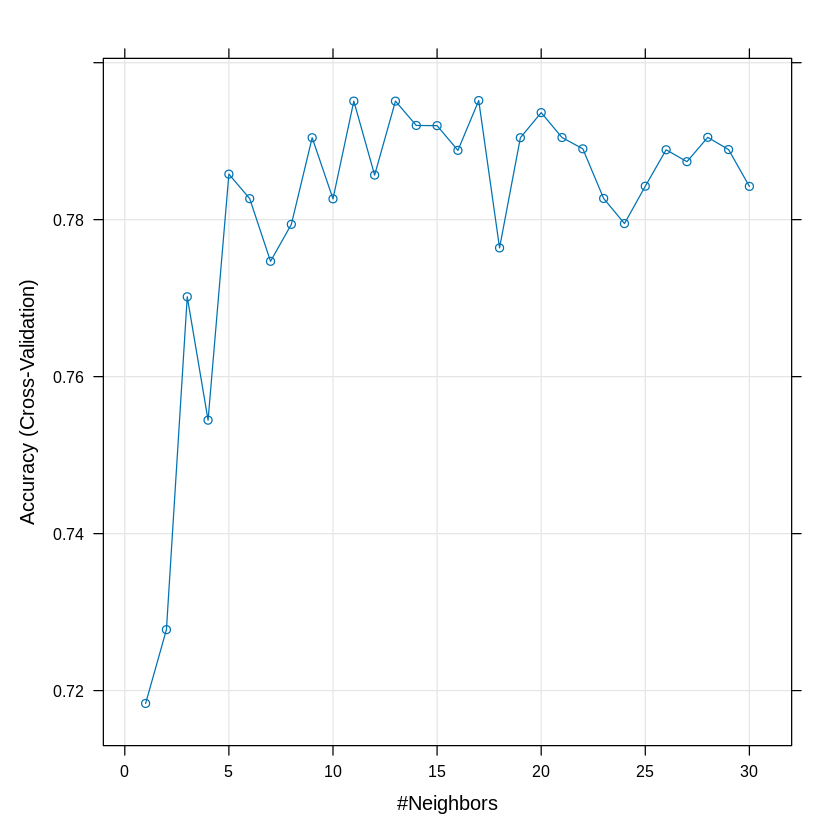

In [ ]:
modeloknn1
plot(modeloknn1)

De los resultados obtenidos podríamos decir que el modelo más parsimonioso con buenos resultados usa k=5, y el modelo seleccionado por el método es de k=17. Sin embargo nótese que estamos usando como medida de precisión “accuracy”. Dado el ligero desbalance de la base de datos, y que nos interesa particularmente predecir los retrasos, quizás sea mejor utilizar otra métrica.

Para poder ver precisión y exhaustividad, hacemos algunos cambios sobre la métrica a manejar.

In [ ]:
levels(cartera.train$retrasos) <- make.names(levels(factor(cartera.train$retrasos)))
# creo parámetros de validación cruzada
cross<-trainControl(method="cv",number=5,
                    classProbs = TRUE,
                    summaryFunction =prSummary)

In [ ]:
set.seed(1)
modeloknn2<-train(retrasos~.,method="knn",
                  tuneGrid=expand.grid(k=1:30),
                  trControl=cross,
                  metric="AUC",
                  data=cartera.train)

k-Nearest Neighbors 

639 samples
 11 predictor
  2 classes: 'X0', 'X1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 512, 511, 511, 511, 511 
Resampling results across tuning parameters:

  k   AUC        Precision  Recall     F        
   1  0.1275890  0.8111728  0.8377446  0.8242251
   2  0.2295012  0.8182565  0.8233958  0.8207001
   3  0.3060409  0.8280345  0.8767936  0.8515490
   4  0.3707907  0.8245192  0.8584052  0.8409794
   5  0.4154850  0.8236750  0.9015148  0.8607887
   6  0.4559147  0.8284000  0.9117400  0.8680089
   7  0.5032315  0.8236209  0.9199032  0.8690774
   8  0.5301042  0.8218236  0.9363139  0.8752834
   9  0.5476826  0.8199147  0.9444982  0.8777939
  10  0.5772772  0.8247693  0.9465601  0.8813993
  11  0.6049659  0.8191475  0.9486009  0.8790997
  12  0.6227466  0.8218379  0.9465601  0.8797410
  13  0.6398199  0.8221219  0.9486009  0.8807579
  14  0.6452839  0.8151261  0.9486219  0.8767214
  15  0.6661761  0.8150738  0.9486009  

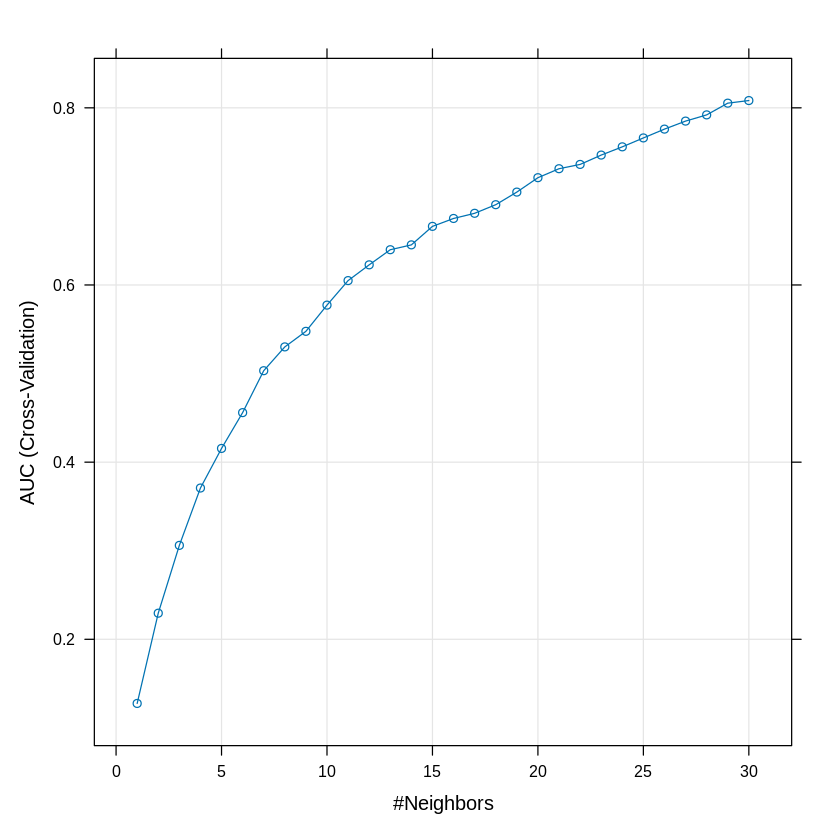

In [ ]:
modeloknn2
plot(modeloknn2)

Este resultado propone un k=30, con el cual vamos a probar el modelo:

In [ ]:
# el modelo sintonizado
predmod1<-predict(modeloknn2,cartera.test,type="prob")
pronknn1<-ifelse(predmod1$X1 > 0.5, 1, 0)
confknn1<-confusionMatrix(as.factor(pronknn1),
                          cartera.test$retrasos, positive = "1")
confknn1$table
confknn1$byClass

          Reference
Prediction   0   1
         0 169  31
         1   3  10

Sensitivity          Specificity       Pos Pred Value 
          0.24390244           0.98255814           0.76923077 
      Neg Pred Value            Precision               Recall 
          0.84500000           0.76923077           0.24390244 
                  F1           Prevalence       Detection Rate 
          0.37037037           0.19248826           0.04694836 
Detection Prevalence    Balanced Accuracy 
          0.06103286           0.61323029

In [ ]:
# el modelo sintonizado
predmod1<-predict(modeloknn2,cartera.test,type="prob")
pronknn1<-ifelse(predmod1$X1 > 0.3, 1, 0)
confknn1<-confusionMatrix(as.factor(pronknn1),
                          cartera.test$retrasos, positive = "1")
confknn1$table
confknn1$byClass

          Reference
Prediction   0   1
         0 138  15
         1  34  26

Sensitivity          Specificity       Pos Pred Value 
           0.6341463            0.8023256            0.4333333 
      Neg Pred Value            Precision               Recall 
           0.9019608            0.4333333            0.6341463 
                  F1           Prevalence       Detection Rate 
           0.5148515            0.1924883            0.1220657 
Detection Prevalence    Balanced Accuracy 
           0.2816901            0.7182360

Aunque KNN también puede usarse para predicciones de variables escalares, KNN es con frecuencia un modelo que puede utilizarse como modelo de base o ingenuo para una clasificación, particularmente con variables predictoras escalares.

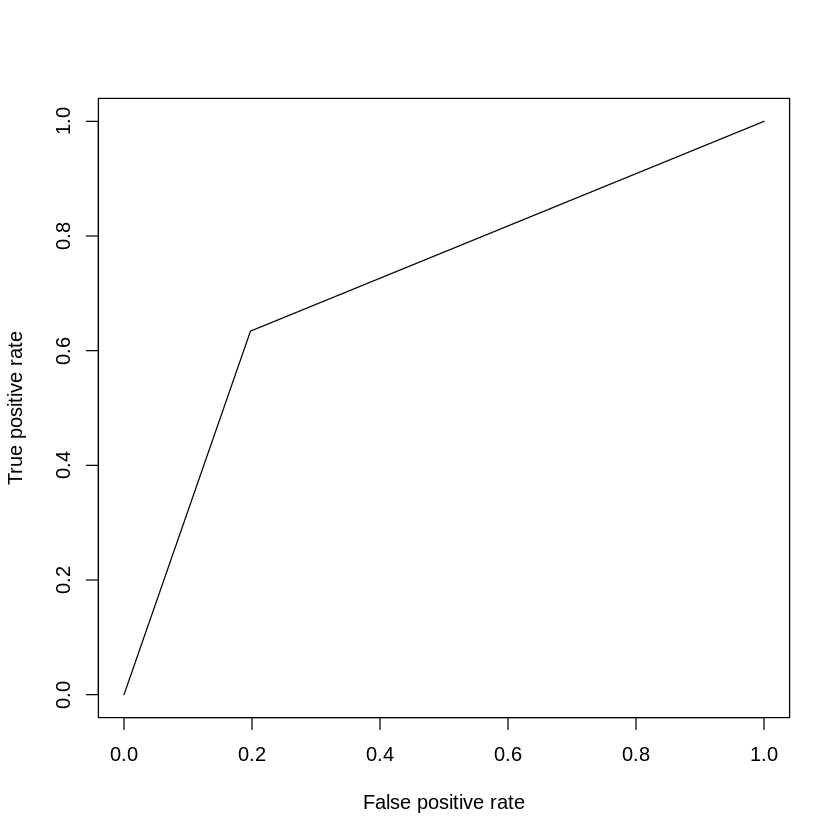

In [ ]:
#crear objeto de predicciones
pr<-prediction(pronknn1,cartera.test$retrasos)
#creacion del objeto de la curva
curvaROC<-performance(pr,measure="tpr",x.measure="fpr")
#grafico de la curva
plot(curvaROC)

In [ ]:
#calcular el AUC
auc<-performance(pr,measure = "auc")
auc <- auc@y.values[[1]]
#ver el AUC
auc

[1] 0.718236

# Uso de la función **KNN3** de **Caret**

https://daviddalpiaz.github.io/stat432sp18/supp/knn_class_r.html

In [45]:
# MODELO CON K = 5
set.seed(1)
test_pred = knn3(retrasos~., data=cartera.train1, k = 5)

In [47]:
# Desempeño en entrenamiento.  K = 5
predmod <- predict(test_pred, cartera.train1, type = "prob")
pronknn<-ifelse(predmod[,2] > 0.3 ,1, 0)
confknn<-confusionMatrix(as.factor(pronknn),
                          cartera.train1$retrasos, positive = "1")
confknn$table
confknn$overall
confknn$byClass

          Reference
Prediction   0   1
         0 399  35
         1  88 117

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
  8.075117e-01   5.259615e-01   7.747671e-01   8.373840e-01   7.621283e-01 
AccuracyPValue  McnemarPValue 
  3.443318e-03   2.749702e-06

Sensitivity          Specificity       Pos Pred Value 
           0.7697368            0.8193018            0.5707317 
      Neg Pred Value            Precision               Recall 
           0.9193548            0.5707317            0.7697368 
                  F1           Prevalence       Detection Rate 
           0.6554622            0.2378717            0.1830986 
Detection Prevalence    Balanced Accuracy 
           0.3208138            0.7945193

In [48]:
# Desempeño en prueba.  K = 5
predmod <- predict(test_pred, cartera.test1, type = "prob")
pronknn<-ifelse(predmod[,2] > 0.3 ,1, 0)
confknn<-confusionMatrix(as.factor(pronknn),
                          cartera.test1$retrasos, positive = "1")
confknn$table
confknn$overall
confknn$byClass

          Reference
Prediction   0   1
         0 134  18
         1  38  23

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
    0.73708920     0.28677350     0.67257400     0.79487613     0.80751174 
AccuracyPValue  McnemarPValue 
    0.99533908     0.01111756

Sensitivity          Specificity       Pos Pred Value 
           0.5609756            0.7790698            0.3770492 
      Neg Pred Value            Precision               Recall 
           0.8815789            0.3770492            0.5609756 
                  F1           Prevalence       Detection Rate 
           0.4509804            0.1924883            0.1079812 
Detection Prevalence    Balanced Accuracy 
           0.2863850            0.6700227

[1] 0.6700227

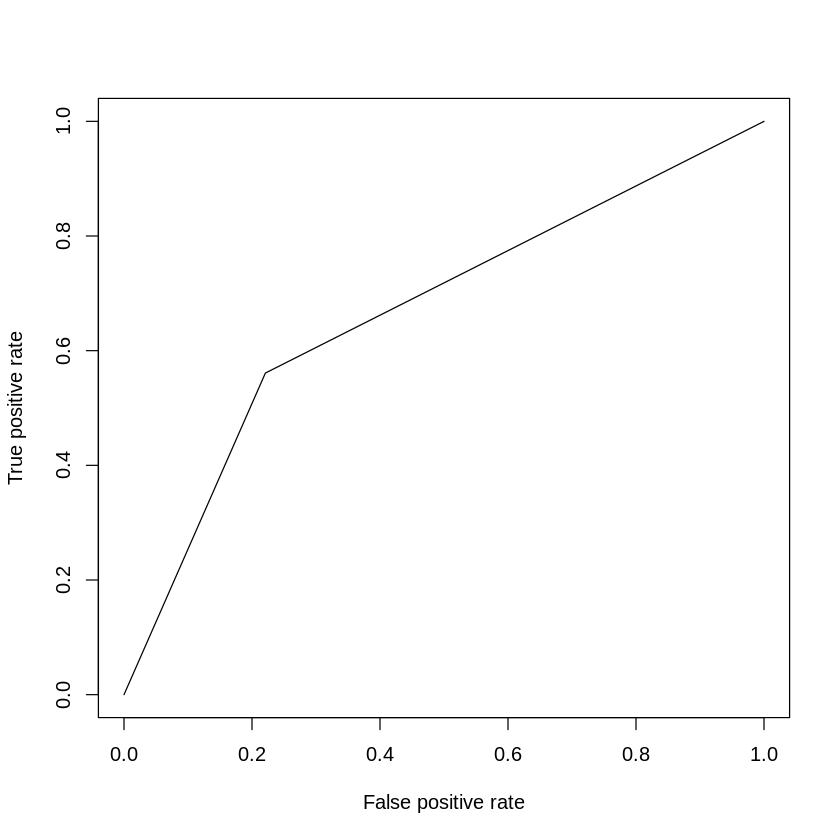

In [49]:
# CURVA ROC y AUC.  K = 5

#crear objeto de predicciones
pr<-prediction(pronknn,cartera.test$retrasos)
#creacion del objeto de la curva
curvaROC<-performance(pr,measure="tpr",x.measure="fpr")
#grafico de la curva
plot(curvaROC)

#calcular el AUC
auc<-performance(pr,measure = "auc")
auc <- auc@y.values[[1]]
#ver el AUC
auc

In [50]:
# MODELO CON K = 17
set.seed(1)
test_pred = knn3(retrasos~., data=cartera.train1, k = 17)

In [51]:
# Desempeño en entranamiento  K = 17
predmod <- predict(test_pred, cartera.train1, type = "prob")
pronknn<-ifelse(predmod[,2] > 0.3 ,1, 0)
confknn<-confusionMatrix(as.factor(pronknn),
                          cartera.train1$retrasos, positive = "1")
confknn$table
confknn$overall
confknn$byClass

          Reference
Prediction   0   1
         0 409  52
         1  78 100

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
    0.79655712     0.47007489     0.76322356     0.82712243     0.76212833 
AccuracyPValue  McnemarPValue 
    0.02148656     0.02833296

Sensitivity          Specificity       Pos Pred Value 
           0.6578947            0.8398357            0.5617978 
      Neg Pred Value            Precision               Recall 
           0.8872017            0.5617978            0.6578947 
                  F1           Prevalence       Detection Rate 
           0.6060606            0.2378717            0.1564945 
Detection Prevalence    Balanced Accuracy 
           0.2785603            0.7488652

In [52]:
# Desempeño en prueba  K = 17
predmod <- predict(test_pred, cartera.test1, type = "prob")
pronknn<-ifelse(predmod[,2] > 0.3 ,1, 0)
confknn<-confusionMatrix(as.factor(pronknn),
                          cartera.test1$retrasos, positive = "1")
confknn$table
confknn$overall
confknn$byClass

          Reference
Prediction   0   1
         0 134  16
         1  38  25

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
   0.746478873    0.322854115    0.682516381    0.803442681    0.807511737 
AccuracyPValue  McnemarPValue 
   0.988623382    0.004266725

Sensitivity          Specificity       Pos Pred Value 
           0.6097561            0.7790698            0.3968254 
      Neg Pred Value            Precision               Recall 
           0.8933333            0.3968254            0.6097561 
                  F1           Prevalence       Detection Rate 
           0.4807692            0.1924883            0.1173709 
Detection Prevalence    Balanced Accuracy 
           0.2957746            0.6944129

[1] 0.6944129

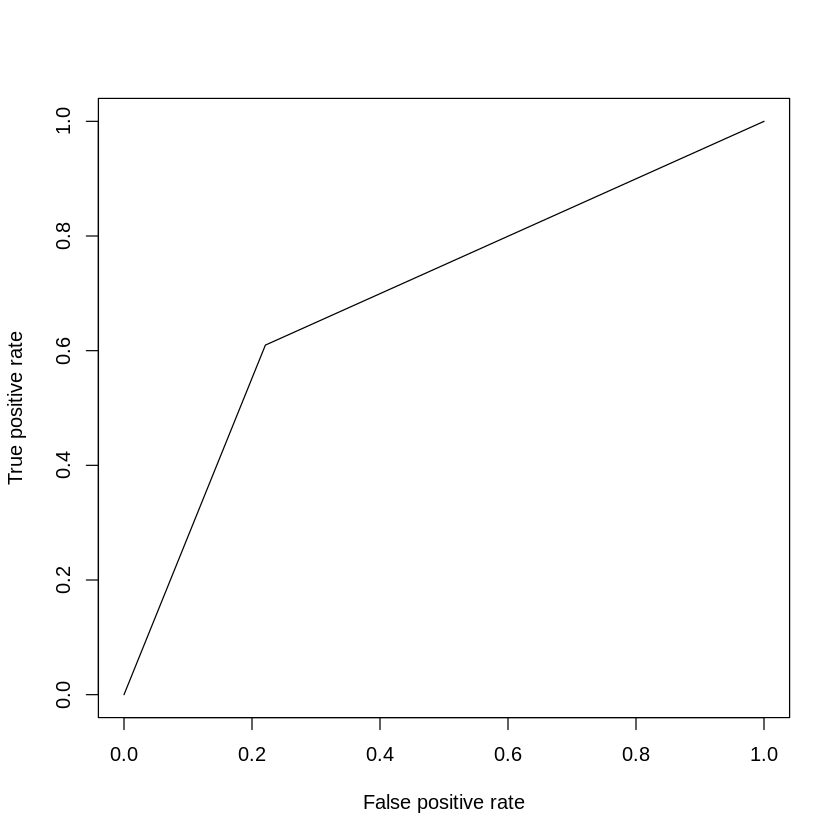

In [54]:
# CURVA ROC y AUC.  K = 17

#crear objeto de predicciones
pr<-prediction(pronknn,cartera.test$retrasos)
#creacion del objeto de la curva
curvaROC<-performance(pr,measure="tpr",x.measure="fpr")
#grafico de la curva
plot(curvaROC)

#calcular el AUC
auc<-performance(pr,measure = "auc")
auc <- auc@y.values[[1]]
#ver el AUC
auc

In [55]:
# MODELO CON K = 30
set.seed(1)
test_pred = knn3(retrasos~., data=cartera.train1, k = 30)

In [56]:
# Desempeño en entrenamiento
predmod <- predict(test_pred, cartera.train1, type = "prob")
pronknn<-ifelse(predmod[,2] > 0.3 ,1, 0)
confknn<-confusionMatrix(as.factor(pronknn),
                          cartera.train1$retrasos, positive = "1")
confknn$table
confknn$overall
confknn$byClass

          Reference
Prediction   0   1
         0 406  54
         1  81  98

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
    0.78873239     0.45086668     0.75499992     0.81977083     0.76212833 
AccuracyPValue  McnemarPValue 
    0.06119877     0.02523908

Sensitivity          Specificity       Pos Pred Value 
           0.6447368            0.8336756            0.5474860 
      Neg Pred Value            Precision               Recall 
           0.8826087            0.5474860            0.6447368 
                  F1           Prevalence       Detection Rate 
           0.5921450            0.2378717            0.1533646 
Detection Prevalence    Balanced Accuracy 
           0.2801252            0.7392062

In [57]:
# Desempeño en prueba
predmod <- predict(test_pred, cartera.test1, type = "prob")
pronknn<-ifelse(predmod[,2] > 0.3 ,1, 0)
confknn<-confusionMatrix(as.factor(pronknn),
                          cartera.test1$retrasos, positive = "1")
confknn$table
confknn$overall
confknn$byClass

          Reference
Prediction   0   1
         0 138  15
         1  34  26

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
    0.76995305     0.37099982     0.70752898     0.82469959     0.80751174 
AccuracyPValue  McnemarPValue 
    0.92767551     0.01012799

Sensitivity          Specificity       Pos Pred Value 
           0.6341463            0.8023256            0.4333333 
      Neg Pred Value            Precision               Recall 
           0.9019608            0.4333333            0.6341463 
                  F1           Prevalence       Detection Rate 
           0.5148515            0.1924883            0.1220657 
Detection Prevalence    Balanced Accuracy 
           0.2816901            0.7182360

[1] 0.718236

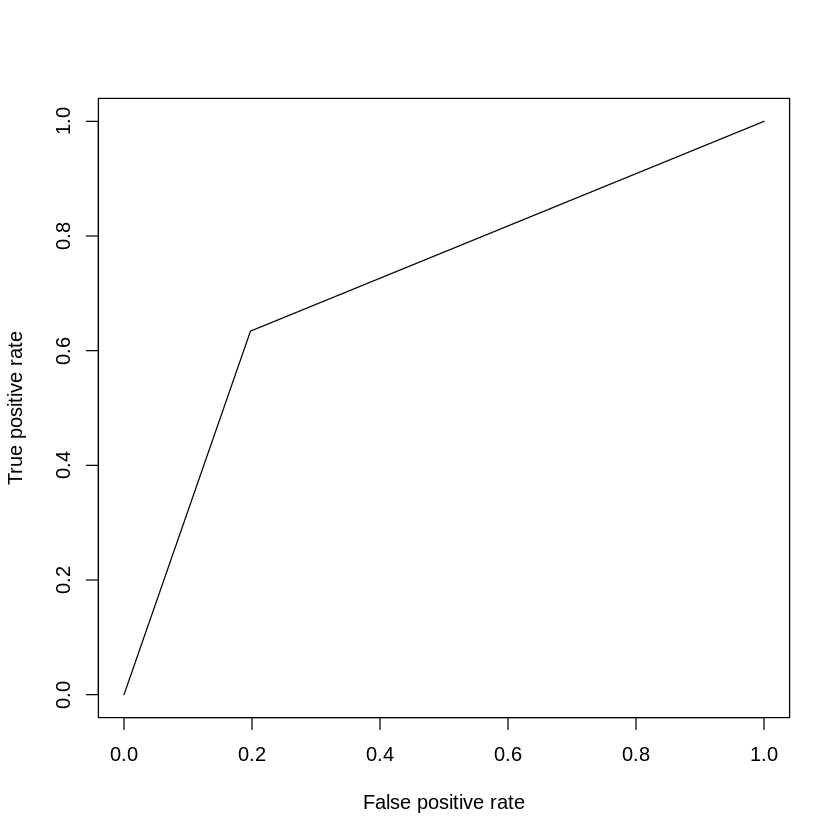

In [58]:
# CURVA ROC y AUC.  K = 30

#crear objeto de predicciones
pr<-prediction(pronknn,cartera.test$retrasos)
#creacion del objeto de la curva
curvaROC<-performance(pr,measure="tpr",x.measure="fpr")
#grafico de la curva
plot(curvaROC)

#calcular el AUC
auc<-performance(pr,measure = "auc")
auc <- auc@y.values[[1]]
#ver el AUC
auc

# Balanceo del dataset de entrenamiento con SMOTE

In [31]:
remotes::install_github("cran/DMwR")
library(DMwR)

zoo      (NA -> 1.8-12) [CRAN]
xts      (NA -> 0.14.0) [CRAN]
TTR      (NA -> 0.24.4) [CRAN]
abind    (NA -> 1.4-5 ) [CRAN]
quantmod (NA -> 0.4.26) [CRAN]


Installing 5 packages: zoo, xts, TTR, abind, quantmod

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpN83TXC/remotes2a4420dab36/cran-DMwR-6fd4f0c/DESCRIPTION’ ... OK
* preparing ‘DMwR’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘DMwR_0.4.1.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: grid

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [32]:
#utilizar SMOTE para crear un nuevo conjunto de datos más equilibrado
cartera.train2 <- SMOTE(retrasos~., as.data.frame(cartera.train1), perc.over = 200, perc.under = 150)
#ver la distribución de la variable de respuesta en el nuevo conjunto de datos
table(cartera.train2$retrasos)


  0   1 
456 456 

In [71]:
# MODELO SMOTE CON K = 5
set.seed(1)
test_pred = knn3(retrasos~., data=cartera.train2, k = 5)

In [72]:
# Desempeño en entrenamiento. SMOTE K = 5
predmod <- predict(test_pred, cartera.train2, type = "prob")
pronknn<-ifelse(predmod[,2] > 0.5 ,1, 0)
confknn<-confusionMatrix(as.factor(pronknn),
                          cartera.train2$retrasos, positive = "1")
confknn$table
confknn$overall
confknn1$byClass

          Reference
Prediction   0   1
         0 370  29
         1  86 427

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
  8.739035e-01   7.478070e-01   8.505977e-01   8.947611e-01   5.000000e-01 
AccuracyPValue  McnemarPValue 
 1.586252e-126   1.769752e-07

Sensitivity          Specificity       Pos Pred Value 
           0.6341463            0.8023256            0.4333333 
      Neg Pred Value            Precision               Recall 
           0.9019608            0.4333333            0.6341463 
                  F1           Prevalence       Detection Rate 
           0.5148515            0.1924883            0.1220657 
Detection Prevalence    Balanced Accuracy 
           0.2816901            0.7182360

In [73]:
# Desempeño en prueba. SMOTE K = 5
predmod <- predict(test_pred, cartera.test1, type = "prob")
pronknn<-ifelse(predmod[,2] > 0.5 ,1, 0)
confknn<-confusionMatrix(as.factor(pronknn),
                          cartera.test1$retrasos, positive = "1")
confknn$table
confknn$overall
confknn$byClass

          Reference
Prediction   0   1
         0 121  15
         1  51  26

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
  6.901408e-01   2.530287e-01   6.233507e-01   7.515473e-01   8.075117e-01 
AccuracyPValue  McnemarPValue 
  9.999851e-01   1.645869e-05

Sensitivity          Specificity       Pos Pred Value 
           0.6341463            0.7034884            0.3376623 
      Neg Pred Value            Precision               Recall 
           0.8897059            0.3376623            0.6341463 
                  F1           Prevalence       Detection Rate 
           0.4406780            0.1924883            0.1220657 
Detection Prevalence    Balanced Accuracy 
           0.3615023            0.6688174

[1] 0.6688174

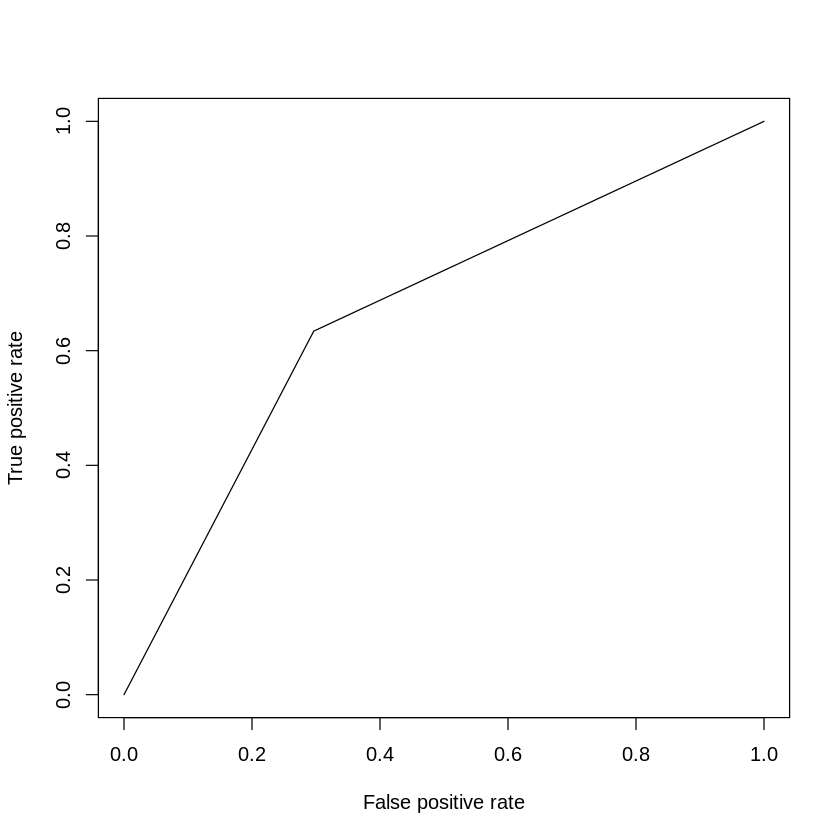

In [74]:
# CURVA ROC y AUC.  SMOTE K = 5

#crear objeto de predicciones
pr<-prediction(pronknn,cartera.test1$retrasos)
#creacion del objeto de la curva
curvaROC<-performance(pr,measure="tpr",x.measure="fpr")
#grafico de la curva
plot(curvaROC)

#calcular el AUC
auc<-performance(pr,measure = "auc")
auc <- auc@y.values[[1]]
#ver el AUC
auc

In [75]:
# MODELO SMOTE CON K = 17
set.seed(1)
test_pred = knn3(retrasos~., data=cartera.train2, k = 17)

In [76]:
# Desempeño en entrenamiento. SMOTE K = 17
predmod <- predict(test_pred, cartera.train2, type = "prob")
pronknn<-ifelse(predmod[,2] > 0.5 ,1, 0)
confknn<-confusionMatrix(as.factor(pronknn),
                          cartera.train2$retrasos, positive = "1")
confknn$table
confknn$overall
confknn$byClass

          Reference
Prediction   0   1
         0 319  64
         1 137 392

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
  7.796053e-01   5.592105e-01   7.512739e-01   8.061174e-01   5.000000e-01 
AccuracyPValue  McnemarPValue 
  1.002446e-67   3.804496e-07

Sensitivity          Specificity       Pos Pred Value 
           0.8596491            0.6995614            0.7410208 
      Neg Pred Value            Precision               Recall 
           0.8328982            0.7410208            0.8596491 
                  F1           Prevalence       Detection Rate 
           0.7959391            0.5000000            0.4298246 
Detection Prevalence    Balanced Accuracy 
           0.5800439            0.7796053

In [77]:
# Desempeño en prueba. SMOTE K = 17
predmod <- predict(test_pred, cartera.test1, type = "prob")
pronknn<-ifelse(predmod[,2] > 0.5 ,1, 0)
confknn<-confusionMatrix(as.factor(pronknn),
                          cartera.test1$retrasos, positive = "1")
confknn$table
confknn$overall
confknn$byClass

          Reference
Prediction   0   1
         0 125   9
         1  47  32

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
  7.370892e-01   3.749083e-01   6.725740e-01   7.948761e-01   8.075117e-01 
AccuracyPValue  McnemarPValue 
  9.953391e-01   7.640502e-07

Sensitivity          Specificity       Pos Pred Value 
           0.7804878            0.7267442            0.4050633 
      Neg Pred Value            Precision               Recall 
           0.9328358            0.4050633            0.7804878 
                  F1           Prevalence       Detection Rate 
           0.5333333            0.1924883            0.1502347 
Detection Prevalence    Balanced Accuracy 
           0.3708920            0.7536160

[1] 0.753616

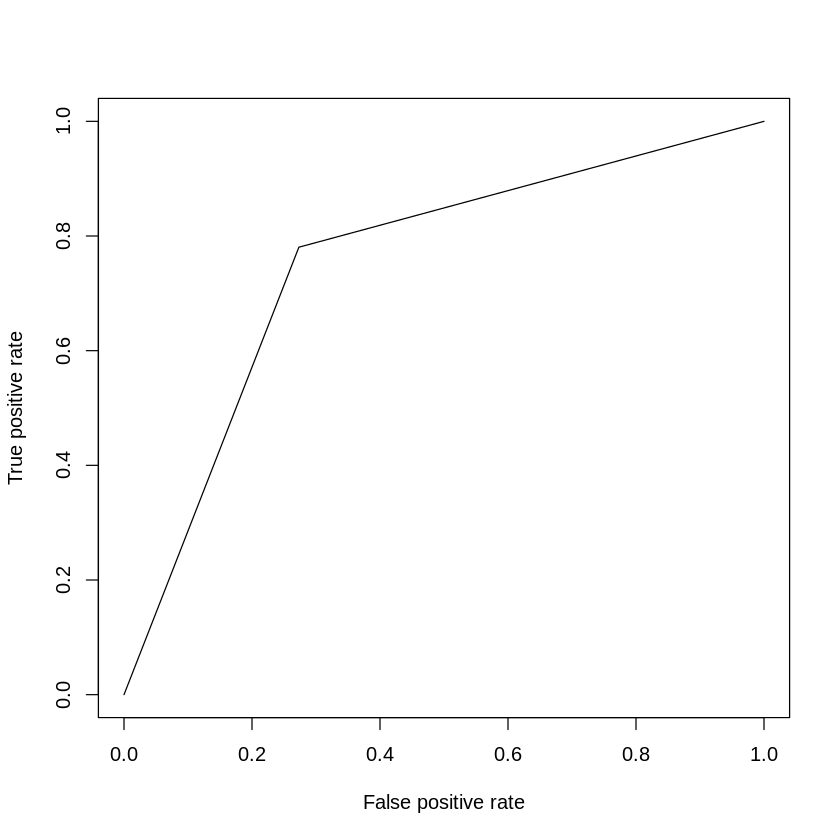

In [78]:
# CURVA ROC y AUC.  SMOTE K = 17

#crear objeto de predicciones
pr<-prediction(pronknn,cartera.test1$retrasos)
#creacion del objeto de la curva
curvaROC<-performance(pr,measure="tpr",x.measure="fpr")
#grafico de la curva
plot(curvaROC)

#calcular el AUC
auc<-performance(pr,measure = "auc")
auc <- auc@y.values[[1]]
#ver el AUC
auc

In [79]:
# MODELO SMOTE CON K = 30
set.seed(1)
test_pred = knn3(retrasos~., data=cartera.train2, k = 30)

In [80]:
# Desempeño en entrenamiento. SMOTE K = 30
predmod <- predict(test_pred, cartera.train2, type = "prob")
pronknn<-ifelse(predmod[,2] > 0.5 ,1, 0)
confknn<-confusionMatrix(as.factor(pronknn),
                          cartera.train2$retrasos, positive = "1")
confknn$table
confknn$overall
confknn$byClass

          Reference
Prediction   0   1
         0 334  94
         1 122 362

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
  7.631579e-01   5.263158e-01   7.341926e-01   7.904120e-01   5.000000e-01 
AccuracyPValue  McnemarPValue 
  8.524208e-60   6.619258e-02

Sensitivity          Specificity       Pos Pred Value 
           0.7938596            0.7324561            0.7479339 
      Neg Pred Value            Precision               Recall 
           0.7803738            0.7479339            0.7938596 
                  F1           Prevalence       Detection Rate 
           0.7702128            0.5000000            0.3969298 
Detection Prevalence    Balanced Accuracy 
           0.5307018            0.7631579

In [81]:
# Desempeño en prueba. SMOTE K = 30
predmod <- predict(test_pred, cartera.test1, type = "prob")
pronknn<-ifelse(predmod[,2] > 0.5 ,1, 0)
confknn<-confusionMatrix(as.factor(pronknn),
                          cartera.test1$retrasos, positive = "1")
confknn$table
confknn$overall
confknn$byClass

          Reference
Prediction   0   1
         0 125  13
         1  47  28

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
  7.183099e-01   3.113482e-01   6.527900e-01   7.776407e-01   8.075117e-01 
AccuracyPValue  McnemarPValue 
  9.993963e-01   2.041694e-05

Sensitivity          Specificity       Pos Pred Value 
           0.6829268            0.7267442            0.3733333 
      Neg Pred Value            Precision               Recall 
           0.9057971            0.3733333            0.6829268 
                  F1           Prevalence       Detection Rate 
           0.4827586            0.1924883            0.1314554 
Detection Prevalence    Balanced Accuracy 
           0.3521127            0.7048355

[1] 0.7048355

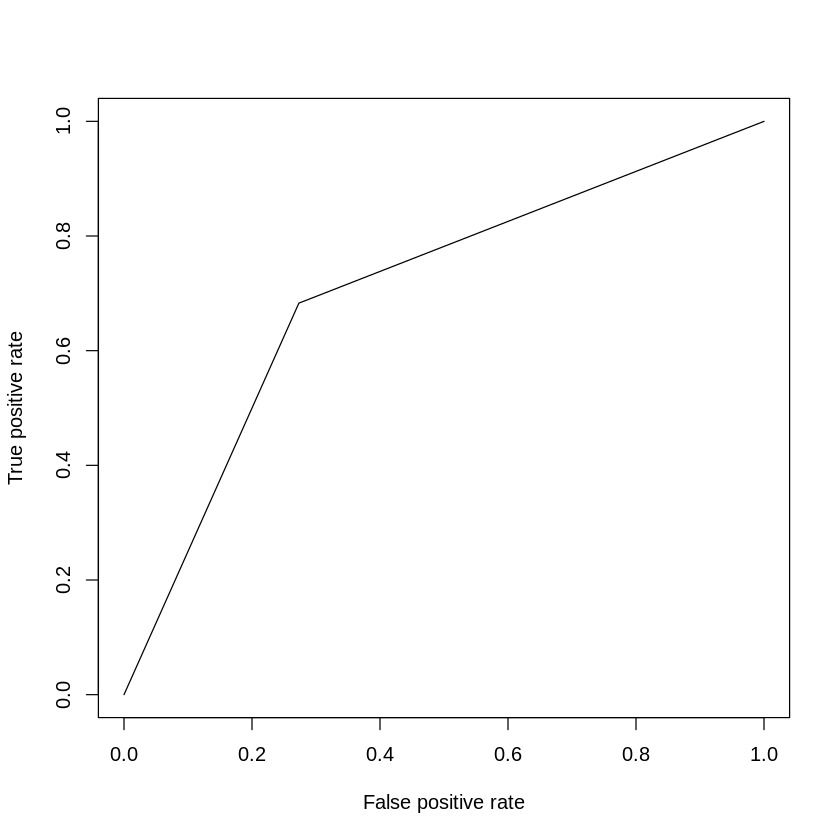

In [82]:
# CURVA ROC y AUC.  SMOTE K = 30

#crear objeto de predicciones
pr<-prediction(pronknn,cartera.test1$retrasos)
#creacion del objeto de la curva
curvaROC<-performance(pr,measure="tpr",x.measure="fpr")
#grafico de la curva
plot(curvaROC)

#calcular el AUC
auc<-performance(pr,measure = "auc")
auc <- auc@y.values[[1]]
#ver el AUC
auc

In [ ]:
set.seed(1)
levels(cartera.train2$retrasos) <- make.names(levels(factor(cartera.train2$retrasos)))
modeloknn3<-train(retrasos~.,method="knn",
                  tuneGrid=expand.grid(k=1:30),
                  trControl=cross,
                  metric="AUC",
                  data=cartera.train2)
modeloknn3

k-Nearest Neighbors 

912 samples
 11 predictor
  2 classes: 'X0', 'X1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 729, 730, 730, 729, 730 
Resampling results across tuning parameters:

  k   AUC         Precision  Recall     F        
   1  0.09997984  0.9437321  0.8617296  0.9001424
   2  0.23485289  0.8877477  0.8134974  0.8486492
   3  0.35408333  0.8799424  0.7629957  0.8151216
   4  0.42571013  0.8603368  0.7345676  0.7912556
   5  0.48376577  0.8500392  0.7301242  0.7844399
   6  0.52164225  0.8362492  0.7322742  0.7792788
   7  0.54983914  0.8394731  0.7279025  0.7780220
   8  0.56840264  0.8465195  0.7300526  0.7819465
   9  0.57595741  0.8482343  0.7322742  0.7855404
  10  0.59677240  0.8436010  0.7169374  0.7740613
  11  0.61074857  0.8400486  0.7213569  0.7751743
  12  0.62884422  0.8473560  0.7169135  0.7750565
  13  0.63854120  0.8444845  0.7279264  0.7801208
  14  0.65338942  0.8247086  0.7126135  0.7632154
  15  0.67078264  0.8168

# ***  Naive Bayes (Bayes ingenuo) ***

Un segundo modelo de clasificación que puede servir como pronóstico base o ingenuo, es conocido como Naive Bayes o Bayes ingenuo.

El resultado se basa en una relajación del Teorema de Bayes en la que la suposición principal es que las variables predictoras son independientes. Aunque es una suposición fuerte, en muchas ocasiones los resultados de Naive Bayes son bastante competitivos, y serán mucho mejores en la medida en que la suposición se cumpla.

# Data and business understanding

Los datos corresponden a una encuesta a 880 personas con respecto a su preferencia entre 3 opciones al desayuno: Avena, Barrita de desayuno o cereal. El objetivo es poder predecir una preferencia de acuerdo a información demográfica disponible que permitiera realizar promociones específicas.

In [83]:
cereal<-read.csv("cereal2.csv", header=TRUE, sep=";", dec=",")
str(cereal)

'data.frame':	880 obs. of  5 variables:
 $ edad_cat: chr  "Menor de 31" "46-60" "Mas de 60" "31-45" ...
 $ genero  : chr  "Hombre" "Hombre" "Hombre" "Mujer" ...
 $ ecivil  : chr  "Casado" "Casado" "Casado" "Casado" ...
 $ activo  : chr  "En activo" "Sin actividad" "Sin actividad" "En activo" ...
 $ desayuno: chr  "Cereales" "Barrita de desayuno" "Avena" "Avena" ...


Los predictores son:

Edadcat: La edad en categorías de edad.

Genero: El género del encuestado

ecivil: el estado civil

activo: Si la persona es o no activo en su vida diaria (sedentario o no)

Vamos a hacer un pequeño arreglo con el nombre de la edad categorizada y separar en bases de entrenamiento y validación en una partición 50%-50%

In [84]:
#un pequeño arreglo
colnames(cereal)[1]<-"edadcat"

In [85]:
#genero entrenamiento y validacion para cereal
set.seed(1)
sample <- sample.int(nrow(cereal), floor(.5*nrow(cereal)))
cereal.train <- cereal[sample, ]
cereal.test <- cereal[-sample, ]

# Modelling

La creación del modelo de Naive Bayes es relativamente simple, pues no existen hiperparámetros por sintonizar o parámetros a entrenar. Se trata simplemente de calcular las probabilidades de la categoría a predecir a partir de las categorías de las predictoras, suponiendo independencia entre ellas usando el Teorema de Bayes.

In [86]:
naivetest<-naiveBayes(cereal.train$desayuno~.,cereal.train)

Un resultado a observar son las probabilidades a priori, que corresponden simplemente a las tasas base de las categorías a predecir. El segundo resultado a observar son las probabilidades marginales del predictor dada la categoría a predecir.

In [87]:
#tasas base
naivetest$apriori

Y
              Avena Barrita de desayuno            Cereales 
                157                 113                 170 

In [88]:
#probabilidades marginales
naivetest$tables$genero

                     genero
Y                        Hombre     Mujer
  Avena               0.4522293 0.5477707
  Barrita de desayuno 0.4247788 0.5752212
  Cereales            0.4882353 0.5117647

In [89]:
naivetest$tables$edadcat


                     edadcat
Y                          31-45      46-60  Mas de 60 Menor de 31
  Avena               0.07643312 0.34394904 0.56687898  0.01273885
  Barrita de desayuno 0.40707965 0.16814159 0.09734513  0.32743363
  Cereales            0.24705882 0.33529412 0.15294118  0.26470588

In [90]:
naivetest$tables$ecivil


                     ecivil
Y                        Casado   Soltero
  Avena               0.6624204 0.3375796
  Barrita de desayuno 0.4690265 0.5309735
  Cereales            0.7058824 0.2941176

In [91]:
naivetest$tables$activo

                     activo
Y                     En activo Sin actividad
  Avena               0.3439490     0.6560510
  Barrita de desayuno 0.6283186     0.3716814
  Cereales            0.4058824     0.5941176

La primera tabla nos permite ver una base de datos bastante balanceada. Las siguientes tablas permiten ver qué característica individual parece discriminar mejor el desayuno elegido.


Por ejemplo, dado que se consume barrita de desayuno hay una mayor probabilidad de que sea mujer, o dado que se consume avena hay una buena probabilidad de que se trate de una persona de más de 42 años, particularmente los mayores de 60.

## Evaluation

Creamos el objeto de predicción que nos permite ver el desempeño en la base de datos de validación

In [92]:
#guarda las probabilidades (para curva ROC)
prednaiveprob<-predict(naivetest, cereal.test, type="raw")

In [93]:
#guarda el pronóstico
prednaive<-predict(naivetest, cereal.test)

In [94]:
cereal.test$desayuno <- as.factor(cereal.test$desayuno)

In [95]:
#generar la matriz de confusión
naiveconf<-confusionMatrix(prednaive,cereal.test$desayuno)
naiveconf$table

                     Reference
Prediction            Avena Barrita de desayuno Cereales
  Avena                 112                  11       43
  Barrita de desayuno     4                  46       35
  Cereales               37                  61       91

In [96]:
naiveconf$byClass

,Sensitivity,Specificity,Pos Pred Value,Neg Pred Value,Precision,Recall,F1,Prevalence,Detection Rate,Detection Prevalence,Balanced Accuracy
Class: Avena,0.7320261,0.8118467,0.6746988,0.8503650,0.6746988,0.7320261,0.7021944,0.3477273,0.2545455,0.3772727,0.7719364
Class: Barrita de desayuno,0.3898305,0.8788820,0.5411765,0.7971831,0.5411765,0.3898305,0.4532020,0.2681818,0.1045455,0.1931818,0.6343562
Class: Cereales,0.5384615,0.6383764,0.4814815,0.6892430,0.4814815,0.5384615,0.5083799,0.3840909,0.2068182,0.4295455,0.5884190


Nótese que la predicción requiere de 3 clases diferentes. Es por ello que la matriz de confusión presenta los indicadores divididos por cada uno de los tres valores, para saber qué tan buena es la predicción para cada posible desayuno. Si se hubiese definido el desayuno a predecir, los resultados hubiesen salido solo para ese tipo de desayuno.

Como puede analizarse, la avena es la más fácil de predecir (F=70%, precisión 67.5% y exhaustividad 73.2%). Para las otras dos clases, los F scores son menores al 50%.

Los siguientes son los pasos para obtener una curva COR para la avena.

In [97]:
#crear resultados 1 o 0 para la predicción de Avena
avenas<-ifelse(cereal.test$desayuno=="Avena",1,0)

In [98]:
prednaiveprob

Avena,Barrita de desayuno,Cereales
0.09691225,0.50459266,0.3984951
0.74023104,0.03447237,0.2252966
0.17330115,0.27984088,0.5468580
0.09691225,0.50459266,0.3984951
0.17330115,0.27984088,0.5468580
0.16418117,0.23713794,0.5986809
0.03438956,0.26799798,0.6976125
0.01274981,0.71169497,0.2755552
0.66177588,0.11109621,0.2271279
0.47621661,0.07058258,0.4532008


In [99]:
#crear el objeto de prediccion
predcor<-prediction(prednaiveprob[,1], avenas)

In [100]:
curvaROC<-performance(predcor,measure="tpr",x.measure="fpr")

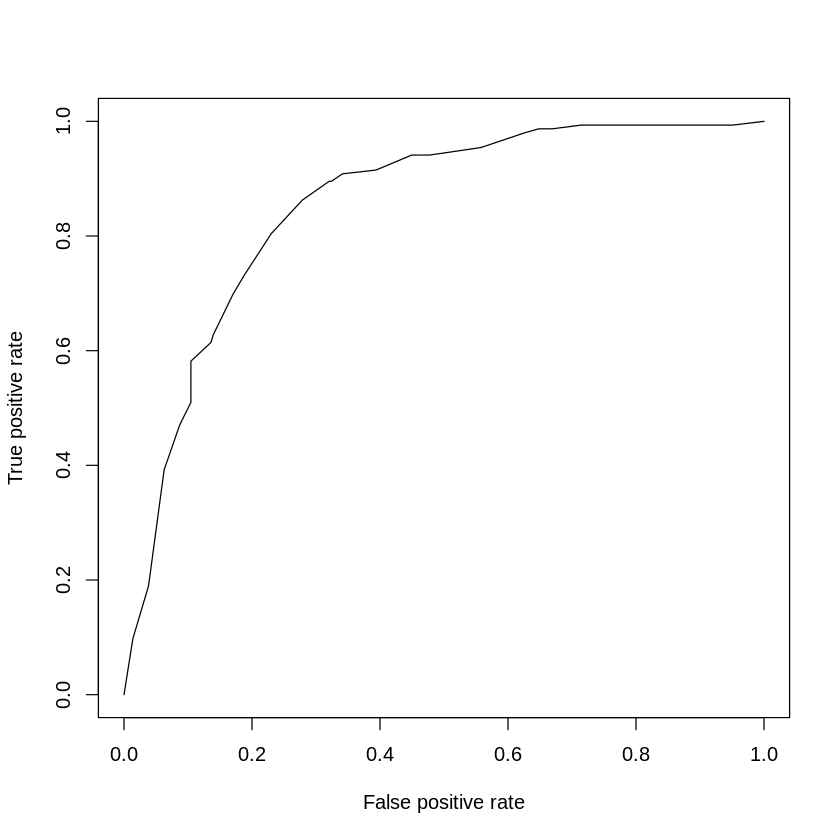

In [101]:
#grafico de la curva
plot(curvaROC)

In [102]:
#calcular el AUC
auc<-performance(predcor,measure = "auc")
auc <- auc@y.values[[1]]
#ver el AUC
auc

[1] 0.8519278

El resultado para avena es bueno. Sin embargo miremos el resultado para cereal.

In [103]:
#crear resultados 1 o 0 para la predicción de cereal
cerealk<-ifelse(cereal.test$desayuno=="Cereales",1,0)

In [104]:
#crear el objeto de prediccion
predcor2<-prediction(prednaiveprob[,3], cerealk)

In [105]:
curvaROC2<-performance(predcor2,measure="tpr",x.measure="fpr")

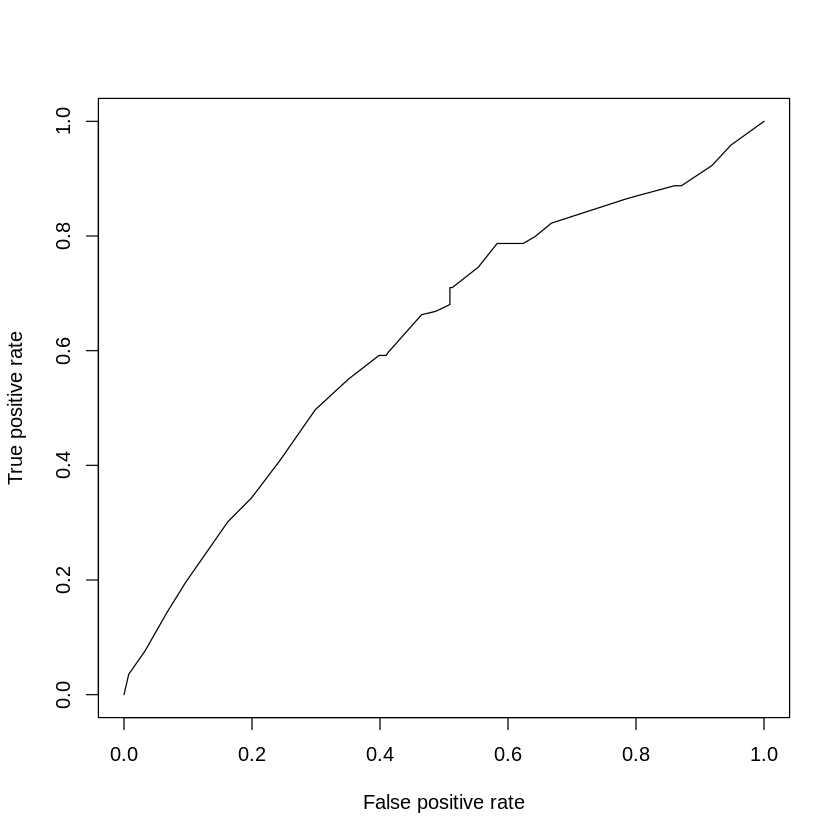

In [106]:
#grafico de la curva
plot(curvaROC2)

In [107]:
#calcular el AUC
auc2<-performance(predcor2,measure = "auc")
auc2<- auc2@y.values[[1]]

In [108]:
#ver el AUC
auc2

[1] 0.6239547

El resultado para cereal es de tan solo 63.4%, por lo que Naive Bayes no es muy satisfactorio para predecir esta categoría.

In [109]:
#guardar las exhaustividades y puntos de corte
tablafinan<-performance(predcor2,measure="rec")
cutoffs<-unlist(tablafinan@x.values)
recalls<-unlist(tablafinan@y.values)

In [110]:
#guardar las precisiones
tablafina2<-performance(predcor2,measure="prec")
precisions<-unlist(tablafina2@y.values)

In [111]:
#guardar f scores
tablafina3<-performance(predcor2,measure="f")
fscores<-unlist(tablafina3@y.values)

In [112]:
#crear la tabla conjunta
tablacruce<-as.data.frame(cbind(cutoffs,precisions,recalls,fscores))

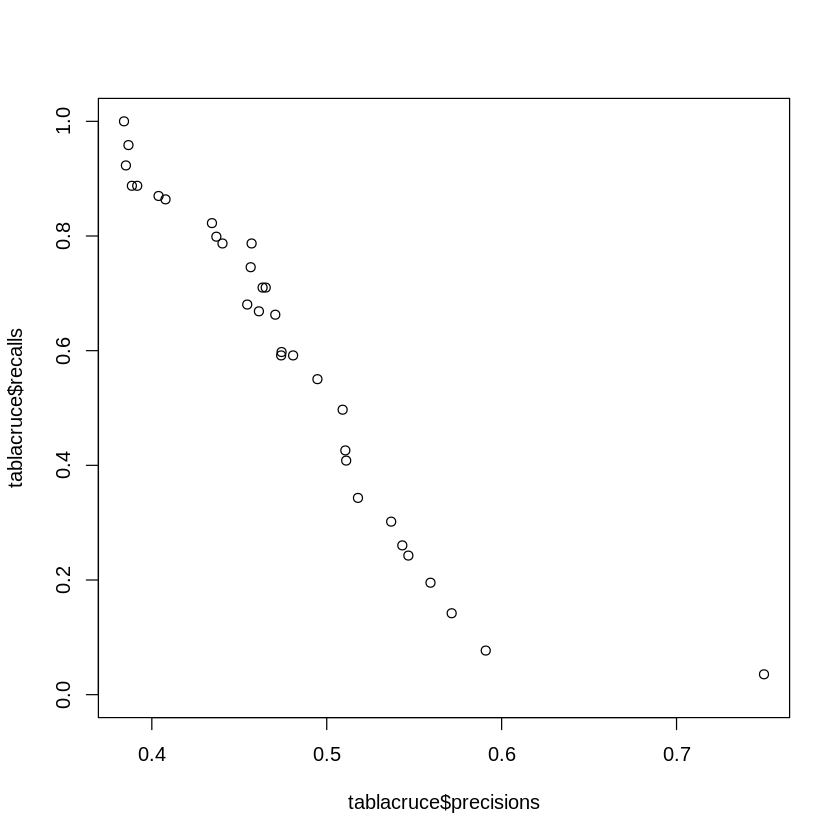

In [113]:
#ver precisiones versus exhaustividad
plot(tablacruce$precisions,tablacruce$recalls)

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


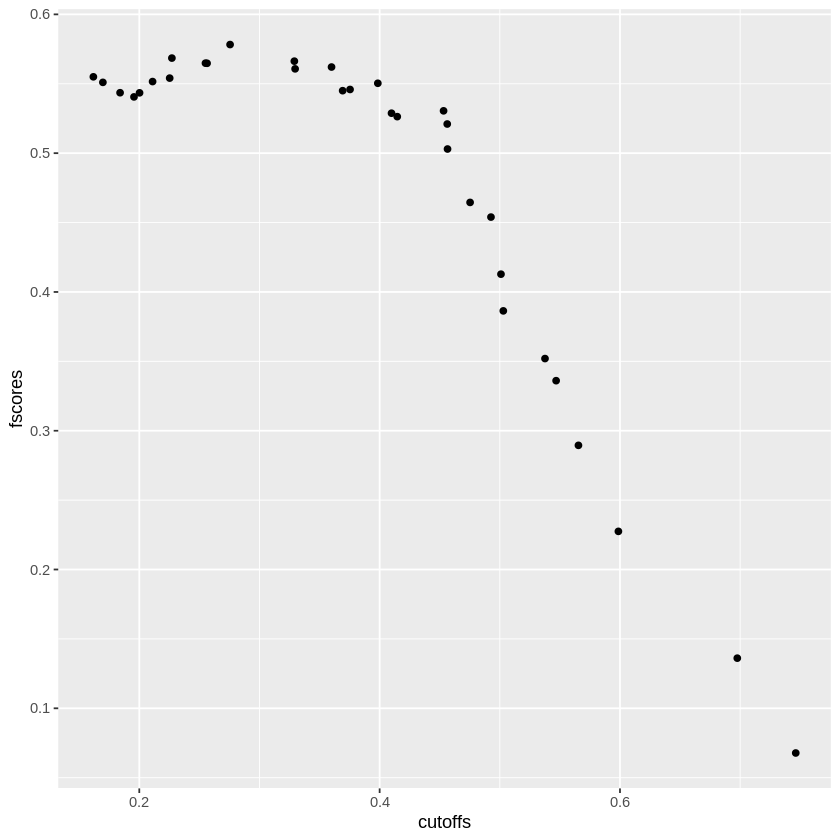

In [114]:
#ver el cutoff que maximiza f score
ggplot(tablacruce, aes(cutoffs,fscores))+geom_point()

## Conclusión

En este libro de notas revisamos dos técnicas básicas de predicción, particularmente de clasificación, que pueden usarse como líneas de base ingenua y que son sorprendentemente buenas a pesar de su sencillez. Un modelo más sofisticado debe demostrar su utilidad frente a modelos ingenuos para justificar el esfuerzo de su realización. Así mismos estas técnicas básicas suelen ser altamente escalables a grandes volúmenes de datos.

